In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-17 00:26:13--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.6’

input.txt.6         100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2023-10-17 00:26:14 (16.0 MB/s) - ‘input.txt.6’ saved [1115394/1115394]



In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encoded = lambda s: [stoi[c] for c in s]
decoded = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(encoded("hello there"))
print(decoded(encoded("hello there")))

[46, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43]
hello there


In [5]:
import torch
tensor_data = torch.tensor(encoded(text), dtype=torch.long)
print(tensor_data[:1000])

/home/ameya/Documents/LLMs/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:20: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

In [6]:
n = int(0.9*len(tensor_data))
train = tensor_data[:n]
valid = tensor_data[n:]
print(train, valid)


tensor([18, 47, 56,  ..., 43, 56, 43]) tensor([12,  0,  0,  ..., 45,  8,  0])


In [7]:
block_size = 8
train[:block_size]

tensor([18, 47, 56, 57, 58,  1, 15, 47])

In [8]:
x = train[:block_size]
y = train[1:block_size+1]
for i in range(block_size):
    context = x[:i+1]
    target = y[i]
    print("Context: ", context, "Target: ", target)

Context:  tensor([18]) Target:  tensor(47)
Context:  tensor([18, 47]) Target:  tensor(56)
Context:  tensor([18, 47, 56]) Target:  tensor(57)
Context:  tensor([18, 47, 56, 57]) Target:  tensor(58)
Context:  tensor([18, 47, 56, 57, 58]) Target:  tensor(1)
Context:  tensor([18, 47, 56, 57, 58,  1]) Target:  tensor(15)
Context:  tensor([18, 47, 56, 57, 58,  1, 15]) Target:  tensor(47)
Context:  tensor([18, 47, 56, 57, 58,  1, 15, 47]) Target:  tensor(58)


In [9]:
torch.manual_seed(1337)
batch_size = 4 
block_size = 8
def get_batch(split):
    data = train if split == 'train' else valid
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i + 1:i+block_size + 1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print("inputs:")
print(xb)
print("targets:")
print(yb)

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input 

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets = None):
        logits = self.token_embedding_table(idx)
        if targets == None:
            loss = None
        else:
            #B, T, C are batch time and channel
            B, T, C = logits.shape
            #This is to reshape it as B, C, T as thats how pytorch wants it
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            #This will only take the last target value from B, C, T
            logits = logits[:, -1, :]
            #Apply softmax and get the probabilities
            prob = F.softmax(logits, dim=-1)#B, C
            #this is to sample from the distribution
            idx_next = torch.multinomial(prob, num_samples=1)#B, 1
            #This will append the sampled index into the running sequence so from B, T you will get B, T+1 T+2 T+3 and so on
            idx = torch.cat((idx, idx_next), dim=1)#B, T+1
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(loss)
#Here we start from a tensor or 0,0 so basically start from 0 and then generate so on
print(decoded(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))



tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [11]:
#ADAMW is a good optimizer for llms and stuff
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [12]:
batch_size = 32
#simple training loop of 10000 iterations
for steps in range(10000):
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.5727508068084717


In [13]:
#as we can see the decoded predicted values are much better than whatever sequence we got above
print(decoded(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


In [14]:
#this entire proccess is done as its more efficient than for loops, here basically current token interacts with all tokens before it to predict the next one and we use matrix multiplication instead of for loop
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))#creates triangular matrix
a /= torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("a = ")
print(a)
print("b = ")
print(b)
print("c = ")
print(c)

a = 
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b = 
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c = 
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [15]:
torch.manual_seed(42)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)


In [16]:
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]#this takes all the tokens before the current token
        xbow[b, t] = torch.mean(xprev, 0)

In [17]:
#this is same thing as above except instead of taking the token as it is we take the weights and multiply
weights = torch.tril(torch.ones(T, T))
weights = weights/ weights.sum(1, keepdim=True)
xbow2 = weights @ x
torch.allclose(xbow, xbow2)#checks if xbow and xbow2 are same

True

In [18]:
#here we do the same as above except we use softmax which is basically taking the exponent and then normalising it out
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros((T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))#here basically if there is a 0 in the matrix replace it with -infinity so that we can take the exponential and future cant communicate with the past
weights = F.softmax(weights, dim=-1)
xbow3 = weights @ x
torch.allclose(xbow, xbow3)

True

In [19]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [20]:
weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

- from above we can see that the values in each row are uniform which isnt good because it means we're giving same importance to all tokens. self attention solves this issue by giving more importance to 1 token over others etc
- the way self attention actually solves this is that each token is given a key and query. Query is basically what the token wants and key is what the token contains and the value is the best match to the current token
- the weight is the dot product of key and query which basically gives the affinity or attention to be given to that token
- a head is basically a mini-brain that helps the model selectively focus on certain aspects of the input data
- one thing to note is the elements across the batch dimension do not interfere with each other
- but in some cases you may want all tokens to interact with each other that is past and future tokens can interact. this is in case of things such as sentiment analysis where you want to see if something is good or bad with respect to the entire context and not just the past and present
. in these cases you can just delete the tril part of the code because it means all tokens can interact with each other
- in self attention the same token produces keys, queries and values but in case of cross attention queries can be produced from 1 nodes and keys and values are produced by other nodes
- after getting the weight we must scale them or else it will be in order of the head size which is why we divide the weight by the square root of head size, in order to get it in 0-1 range. if you dont do this then softmax will give very extreme values
- 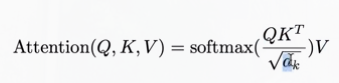
- multi-head attention is basically many self-attention heads working in parallel
- feed forward is basically the thinking part of the attention mechanism

In [21]:
#self attention approach
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=True)
k = key(x) #B, T, 16
q = query(x) #B, T, 16

weights = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v

out

tensor([[[-2.8991e-01,  8.6736e-01,  1.5501e-01, -6.5131e-01, -2.7023e-01,
           7.8589e-01,  5.7559e-02, -4.9535e-01, -9.7129e-01,  3.4192e-01,
           1.8012e-01, -7.4462e-01, -3.9583e-01, -5.3873e-01,  4.4231e-01,
           5.4113e-01],
         [ 5.4365e-01, -5.6043e-01, -2.5430e-01,  4.4537e-01, -2.5532e-01,
          -2.5607e-01, -4.7274e-01, -8.0318e-02, -1.3331e-01,  8.7804e-01,
           7.1691e-01, -2.6675e-01,  4.1206e-01,  2.9041e-01,  8.5100e-02,
           1.2417e+00],
         [ 3.4949e-01, -1.1961e-01, -4.1205e-01,  3.0803e-01,  3.0768e-02,
          -1.3053e-01, -2.6905e-02,  5.0101e-02, -3.3306e-01, -2.2600e-01,
           2.8263e-01,  1.2588e-02, -2.0410e-01, -1.2035e-01,  1.4451e-02,
           1.1896e+00],
         [ 6.4300e-02,  2.7288e-01, -1.3678e-01, -1.3444e-01, -6.0558e-02,
           2.3449e-01, -1.5048e-02, -2.1652e-01, -5.4869e-01,  2.2054e-01,
           1.5680e-01, -3.5360e-01, -1.6247e-01, -2.1488e-01,  3.5082e-01,
           7.3793e-01],
    

In [23]:
print(loss)

tensor(2.5728, grad_fn=<NllLossBackward0>)


- residual block is important as it helps improve computation. basically you take a fork of the input perform the computation and send the output back to the residual pathway. residual pathway is just the input->target path
- we must also add a dropout layer at the end so that its more efficient and reduces overfitting

In [27]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
weights = q @ k.transpose(-2, -1)*head_size**-0.5

In [31]:
k.var()

tensor(0.8793)

In [29]:
q.var()

tensor(1.0217)

In [30]:
weights.var()

tensor(1.0032)

In [33]:
#the below code is for batch layer normalisation which is basically batch normalisation but instead of columns we normalise rows
from typing import Any


class LayerNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    
    def __call__(self, x):
        xmean = x.mean(1, keepdim=True)#batch mean
        xvar = x.var(1, keepdim=True)#batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)#normalise to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100)#batch size 32 of 100 dimensional vectors
x = module(x)
x

tensor([[ 0.1335, -0.1059, -0.3824,  ..., -1.3422, -0.1971,  0.8795],
        [-0.0353, -0.7439, -0.3371,  ..., -0.6276, -0.4846,  0.4556],
        [ 0.3069, -1.5010,  1.4898,  ..., -0.6819,  0.9993,  0.8382],
        ...,
        [-1.6080, -1.6324, -0.7634,  ..., -0.9847,  0.0039, -0.8610],
        [-0.2273,  0.0066, -0.2763,  ..., -0.8705, -1.2442, -0.7531],
        [ 0.3054, -0.1505, -0.3809,  ..., -1.4962, -0.7711, -1.0681]])

In [35]:
x[:, 0].mean(), x[:, 0].std() #mean, std dev of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [38]:
x[0, :].mean(), x[0, :].std() #mean, std dev of a single input from the batch of its features
#this wont give you the exact predicted output (as in the sentences may not make sense) but it should give you a shakespearian like language

(tensor(-9.5367e-09), tensor(1.0000))

- note that this is a decoder model which basically means it just gives some random output based on input
- in an encoder-decoder model, the input is encoded the computed then decoded (for example language translation)
- in the encoder-decoder model there is no triangular mask so the tokens can freely interact with each other which is required to make senseful sentences